# Trabalho Final - Parte 1: Análise e Previsão de Fatalidade em Acidentes de Trânsito

---

## **Introdução**

Acidentes de trânsito com fatalidades representam uma tragédia social de grande impacto. O principal objetivo deste projeto é, a partir da análise exploratória e da modelagem de dados, construir um modelo de Machine Learning capaz de prever a probabilidade de um acidente de trânsito ser fatal.

O dataset utilizado foi obtido da base de dados do DENATRAN - 2025, com detalhamento de diversos acidentes ocorridos. A motivação central é utilizar esses dados para identificar os principais fatores de risco que contribuem para a gravidade dos acidentes. Este estudo é importante para fundamentar políticas públicas e campanhas de conscientização mais eficazes, e orientar estratégias para aumentar a segurança das vias. Por exemplo, se a análise revelar que a maioria dos acidentes fatais ocorre em um tipo específico de via ou em um determinado período do dia, as autoridades poderão direcionar seus recursos de fiscalização e infraestrutura de forma mais inteligente.

Nosso objetivo é prever a probabilidade de um acidente resultar em fatalidade (morte). Para isso, exploraremos o conjunto de dados buscando identificar padrões e fatores de risco relacionados à gravidade dos acidentes, como horário, tipo de via, condição climática e fase do dia. A partir dessa análise, será possível compreender os principais determinantes de acidentes fatais e orientar a preparação dos dados para o modelo preditivo.


##Base de dados escolhida:

### Descrição da base de dados escolhida

A base foi obtida do portal de dados abertos da Polícia Rodoviária Federal(PRF), disponível através do link :  
[https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf](https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf)

Cada linha representa um acidente de trânsito registrado pela PRF.  
A base contém informações sobre o **local, data, horário, tipo de via, condições climáticas, tipo e causa do acidente**, além do **número de vítimas e veículos envolvidos**.

**Principais colunas:**
- data_inversa → Data do acidente (tipo *object*, formato data)  
- horario → Hora aproximada do acidente  
- uf → Unidade Federativa onde ocorreu o acidente  
- municipio → Cidade  
- causa_acidente → Motivo provável (ex.: falta de atenção, velocidade incompatível)  
- tipo_acidente → Natureza do acidente (colisão, atropelamento etc.)  
- classificacao_acidente → Gravidade (com morte, com feridos, sem vítimas)  
- fase_dia → Período (dia, noite, amanhecer, anoitecer)  
- condicao_metereologica → Clima no momento (chuva, cerração, bom tempo)  
- tipo_pista e tracado_via → Características da via  
- mortos, feridos_graves, feridos_leves, ilesos → Número de vítimas  
- veiculos → Total de veículos envolvidos  




### Adicionando bibliotecas

Importando as bibliotecas utilizadas para analisar e tratar os dados:

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# from lightgbm import LGBMRegressor
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import mean_squared_error, r2_score

### Análise exploratórias dos dados

Nessa etapa, fazemos a leitura a base de dados inicial, para estudo das colunas e entender as principais váriaveis (colunas) que serão consideradas no estudo e as que serão removidas:

In [ ]:
# Lendo a base inicial
def ler_base_inicial(rodar_local = True):

  if(rodar_local):
    base = pd.read_csv('/content/datatran2025.csv', encoding='latin1', sep=';')
    base.columns
  else:
    from google.colab import drive
    file_path = '/content/drive/MyDrive/Databases Projeto/datatran2025.xlsx'

    # Carregue o DataFrame
    try:
        base = pd.read_excel(file_path)#, encoding='latin1', sep=';')
        print("DataFrame carregado com sucesso!")
    except FileNotFoundError:
        print(f"Erro: O arquivo não foi encontrado no caminho especificado: {file_path}")
    except Exception as e:
        print(f"Ocorreu um erro ao carregar o arquivo: {e}")
  base.columns

  return base

base = ler_base_inicial(True)
base.columns

Index(['id', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br', 'km',
       'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'ilesos',
       'ignorados', 'feridos', 'veiculos', 'latitude', 'longitude', 'regional',
       'delegacia', 'uop'],
      dtype='object')

##Limpeza dos dados


Durante a preparação da base, realizamos os seguintes ajustes:

- **Remoção de duplicatas:** Foram removidas linhas idênticas que poderiam enviesar estatísticas e correlações.  
- **Remoção da coluna id:** Trata-se de um identificador único, sem relevância analítica.  
- **Tratamento de valores faltantes:** Colunas como regional, delegacia e uop apresentavam valores ausentes, preenchidos com o símbolo '-' para manter a consistência.    
- **Tipos de dados:** Algumas colunas categóricas foram convertidas para numéricas (com *LabelEncoder*) para permitir cálculos de correlação.

Não houve necessidade de normalização numérica nesta etapa, pois ainda estamos apenas explorando padrões gerais.



In [ ]:
def limpar_dados(base):
  # Tirando duplicatas
  base_limpa = base.drop_duplicates()

  # Removendo colunas irrelevantes (ID)
  base_limpa = base_limpa.drop(columns={'id'})

  # Lidando com NaNs
  base_limpa.loc[base_limpa['classificacao_acidente'].isna(), 'classificacao_acidente'] = '-'
  base_limpa.loc[base_limpa['regional'].isna(), 'regional'] = '-'
  base_limpa.loc[base_limpa['delegacia'].isna(), 'delegacia'] = '-'
  base_limpa.loc[base_limpa['uop'].isna(), 'uop'] = '-'

  # Marcando acidentes fatais
  base_limpa.loc[base_limpa['mortos'] > 0, 'classificacao_acidente'] = 'com vitimas fatais'

  # Deixando as strings em minusculo
  colunas_string = base_limpa.select_dtypes(include=['object']).columns
  for col in colunas_string:
      if(col not in ['horario']):
        base_limpa[col] = base_limpa[col].str.lower()

  # Corrigindo caracteres
  base_limpa['classificacao_acidente'] = base_limpa['classificacao_acidente'].str.replace('�', 'i')
  return base_limpa

base_limpa = limpar_dados(base)
base_limpa.head(10)

,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tracado_via,uso_solo,pessoas,mortos,feridos_leves,feridos_graves,ilesos,ignorados,feridos,veiculos,latitude,longitude,regional,delegacia,uop
0,01/01/2025,quarta-feira,06:20:00,sp,116,225,guarulhos,reaï¿½ï¿½o tardia ou ineficiente do cond,tombamento,com vï¿½timas ferid,pleno dia,decrescente,cï¿½u cla,mï¿½ltip,reta;declive,sim,2,0,1,0,0,1,1,2,"-23,48586772","-46,54075317",sprf-sp,del01-sp,uop01-del01-sp
1,01/01/2025,quarta-feira,07:50:00,ce,116,"546,2",penaforte,pista esburacada,colisï¿½o front,com vitimas fatais,pleno dia,crescente,cï¿½u cla,simples,reta,nï¿,6,1,1,0,1,4,1,6,"-7,812288","-39,08333306",sprf-ce,del05-ce,uop03-del05-ce
2,01/01/2025,quarta-feira,08:45:00,pr,369,"88,2",cornelio procopio,reaï¿½ï¿½o tardia ou ineficiente do cond,colisï¿½o trasei,com vï¿½timas ferid,pleno dia,crescente,sol,dupla,reta;aclive,sim,5,0,3,0,2,0,3,2,"-23,182565","-50,637228",sprf-pr,del07-pr,uop05-del07-pr
3,01/01/2025,quarta-feira,11:00:00,pr,116,74,campina grande do sul,reaï¿½ï¿½o tardia ou ineficiente do cond,saï¿½da de leito carroï¿½,com vï¿½timas ferid,pleno dia,crescente,cï¿½u cla,dupla,reta,nï¿,5,0,1,0,4,0,1,2,"-25,36517687","-49,04223028",sprf-pr,del01-pr,uop02-del01-pr
4,01/01/2025,quarta-feira,09:30:00,mg,251,471,francisco sa,velocidade incompatï¿½v,colisï¿½o front,com vï¿½timas ferid,pleno dia,decrescente,chuva,simples,curva;declive,nï¿,5,0,1,1,1,2,2,4,"-16,46801304","-43,43121303",sprf-mg,del12-mg,uop01-del12-mg
5,01/01/2025,quarta-feira,10:40:00,mt,70,669,caceres,transitar na contramï¿,colisï¿½o front,com vitimas fatais,pleno dia,crescente,cï¿½u cla,simples,reta,nï¿,4,2,0,0,1,2,0,5,"-16,04148578","-57,25884017",sprf-mt,del03-mt,uop02-del03-mt
6,01/01/2025,quarta-feira,12:23:00,rs,116,376,tapes,ausï¿½ncia de reaï¿½ï¿½o do co,saï¿½da de leito carroï¿½,com vï¿½timas ferid,pleno dia,decrescente,cï¿½u cla,dupla,reta,nï¿,2,0,1,0,0,1,1,2,"-30,739714","-51,62594",sprf-rs,del02-rs,uop02-del02-rs
7,01/01/2025,quarta-feira,17:45:00,sc,101,"207,4",sao jose,ausï¿½ncia de reaï¿½ï¿½o do co,colisï¿½o trasei,com vï¿½timas ferid,pleno dia,crescente,nublado,dupla,reta,sim,2,0,1,0,1,0,1,2,"-27,60001226","-48,6226467",sprf-sc,del01-sc,uop01-del01-sc
8,01/01/2025,quarta-feira,18:40:00,mg,116,"708,5",muriae,velocidade incompatï¿½v,tombamento,com vitimas fatais,anoitecer,crescente,nublado,simples,curva,nï¿,2,1,0,0,0,1,0,2,"-21,16328873","-42,37968988",sprf-mg,del07-mg,uop02-del07-mg
9,01/01/2025,quarta-feira,17:00:00,pe,407,"7,4",afranio,demais falhas mecï¿½nicas ou elï¿½tr,incï¿½nd,sem vï¿½tim,pleno dia,crescente,cï¿½u cla,simples,aclive;curva,nï¿,2,0,0,0,2,0,0,1,"-8,47503105","-41,0137105",sprf-pe,del06-pe,uop02-del06-pe


#### Explorando os dados

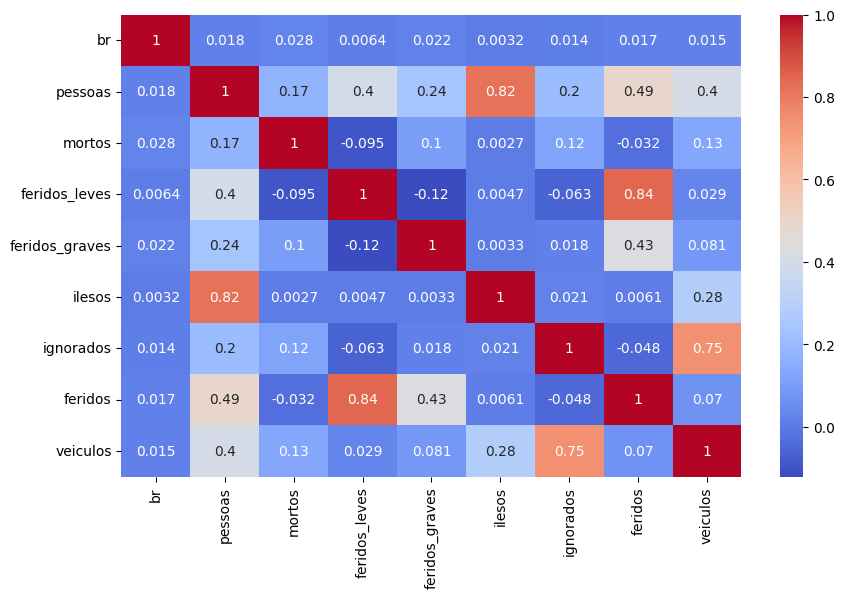

In [ ]:
# Correlação numérica
base_numerica = base_limpa.select_dtypes(include=['number'])
corr = base_numerica.corr()

plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

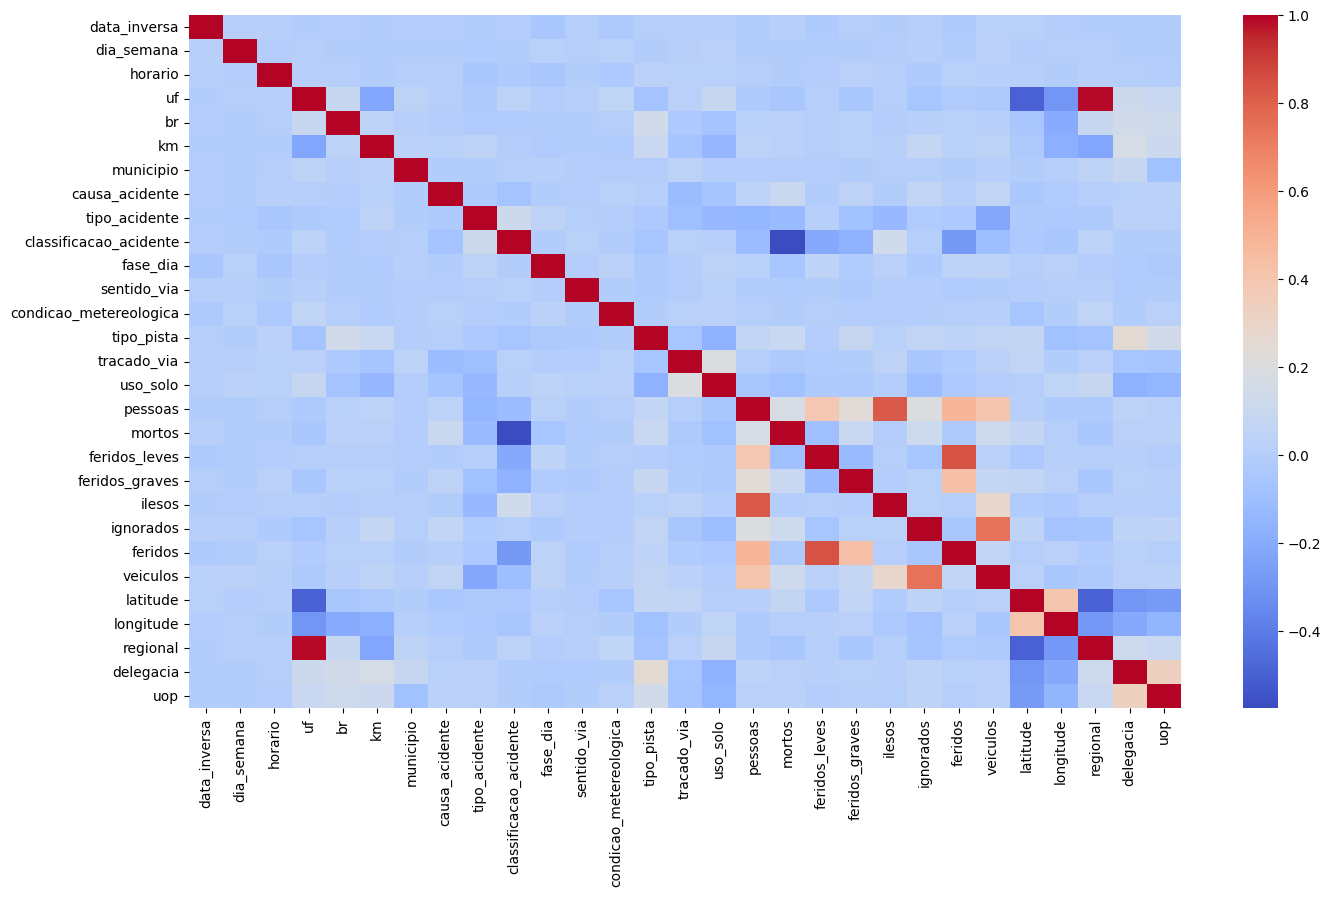

In [ ]:
# Correlação adicionando variáveis de texto
from sklearn.preprocessing import LabelEncoder

base_limpa_encoded = base_limpa.copy()

# Converte colunas de texto em números
for col in base_limpa.select_dtypes(include=['object']):
    base_limpa_encoded[col] = LabelEncoder().fit_transform(base_limpa_encoded[col].astype(str))

# Agora pode calcular a correlação normalmente
corr = base_limpa_encoded.corr()
plt.figure(figsize=(16,9))
sns.heatmap(corr, cmap='coolwarm')
plt.show()

## Pergunta 1 — Qual o tipo de acidente mais comum?

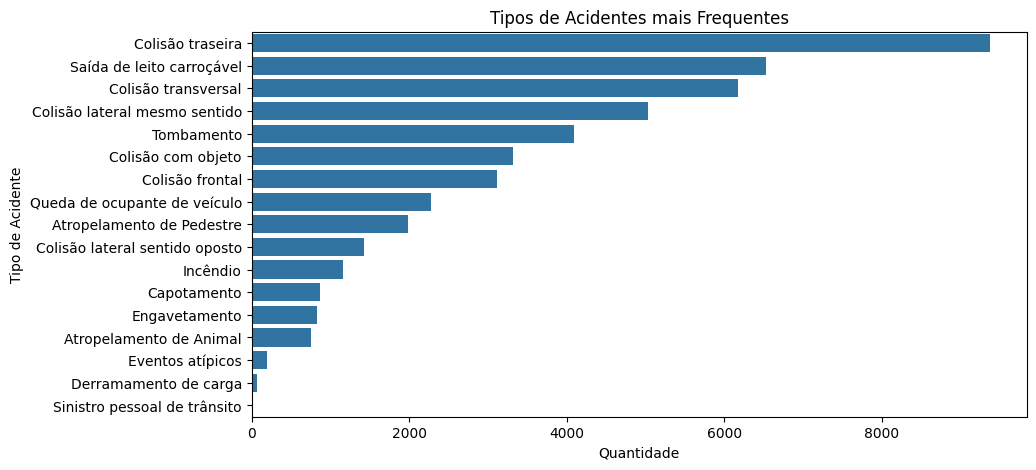

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(y='tipo_acidente', data=base_limpa, order=base_limpa['tipo_acidente'].value_counts().index)
plt.title('Tipos de Acidentes mais Frequentes')
plt.xlabel('Quantidade')
plt.ylabel('Tipo de Acidente')
plt.show()

**Conclusão:** As colisões traseiras e saídas de pista são os tipos mais

---

frequentes, representando a maior parte dos registros.

## Pergunta 2 — Qual a distribuição de acidentes por dia da semana?

In [ ]:
base_limpa['dia_semana'].value_counts()

,count
dia_semana,
sábado,7513
domingo,7472
sexta-feira,7313
segunda-feira,6608
quarta-feira,6240
quinta-feira,6231
terça-feira,5815


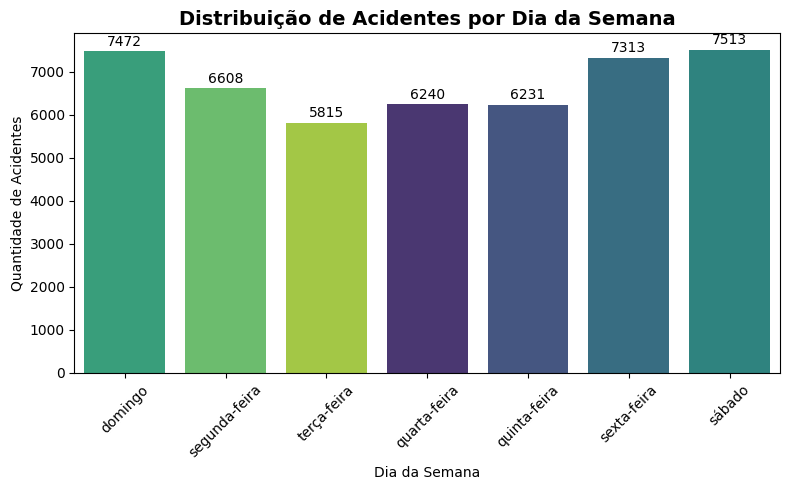

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Corrige os nomes com problema de acento
base_limpa['dia_semana'] = base_limpa['dia_semana'].replace({
    'tera-feira': 'terça-feira',
    'sbado': 'sábado'
})

# Gera o gráfico
plt.figure(figsize=(8,5))
grafico = sns.countplot(
    x='dia_semana',
    data=base_limpa,
    order=['domingo','segunda-feira','terça-feira','quarta-feira','quinta-feira','sexta-feira','sábado'],
    hue='dia_semana',
    legend=False,
    palette='viridis'
)

# Título e rótulos
plt.title('Distribuição de Acidentes por Dia da Semana', fontsize=14, weight='bold')
plt.xlabel('Dia da Semana')
plt.ylabel('Quantidade de Acidentes')
plt.xticks(rotation=45)

# Adiciona os números acima das barras
for p in grafico.patches:
    grafico.annotate(
        format(p.get_height(), '.0f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center',
        xytext=(0, 7),
        textcoords='offset points'
    )

plt.tight_layout()
plt.show()


**Conclusão:** Há maior concentração de acidentes nos finais de semana, sugerindo correlação com aumento de fluxo e consumo de álcool.

## Pergunta 3 — Em que horários os acidentes mais ocorrem?

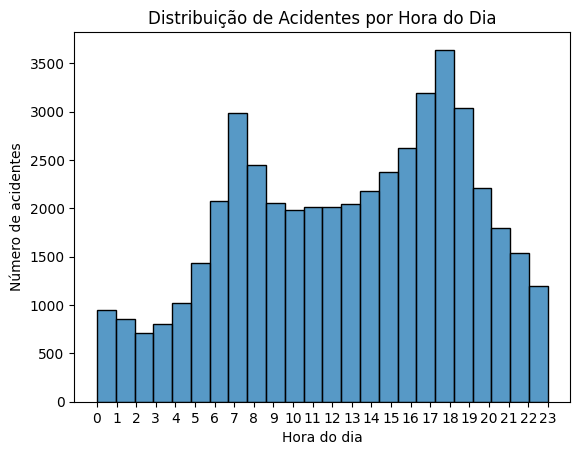

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Converte para string e extrai os dois primeiros caracteres
horas_str = base_limpa['horario'].astype(str).str[:2]

# Tenta converter para inteiro, valores inválidos viram NaN
horas_int = pd.to_numeric(horas_str, errors='coerce')

# Mantém apenas horários válidos (0 a 23)
base_limpa['hora'] = horas_int[(horas_int >= 0) & (horas_int <= 23)]

# Remove valores nulos
base_limpa = base_limpa.dropna(subset=['hora'])

# Plot do histograma
sns.histplot(base_limpa['hora'], bins=24)
plt.title('Distribuição de Acidentes por Hora do Dia')
plt.xlabel('Hora do dia')
plt.ylabel('Número de acidentes')
plt.xticks(range(0,24))
plt.show()


**Conclusão:** Picos de acidentes são observados entre 6h e 9h da manhã e também entre 17h e 20h noite, horários de maior tráfego urbano.

## Pergunta 4 — As condições climáticas influenciam a gravidade dos acidentes?

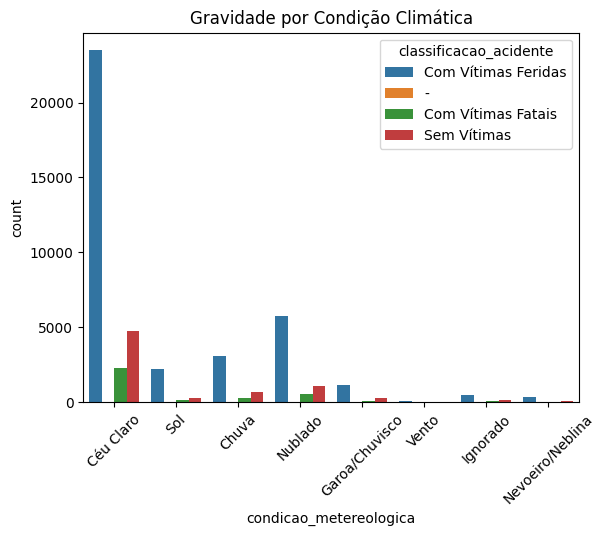

In [ ]:
sns.countplot(x='condicao_metereologica', hue='classificacao_acidente', data=base_limpa)
plt.title('Gravidade por Condição Climática')
plt.xticks(rotation=45)
plt.show()

**Conclusão:** A maioria dos acidentes fatais ocorre em tempo bom, o que sugere que o clima não é o único fator determinante.

## Pergunta 5 — Qual fase do dia apresenta mais acidentes fatais?

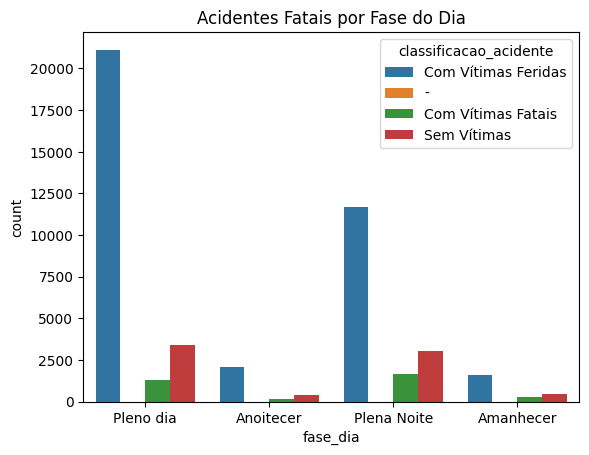

In [ ]:
sns.countplot(x='fase_dia', hue='classificacao_acidente', data=base_limpa)
plt.title('Acidentes Fatais por Fase do Dia')
plt.show()

**Conclusão:** Acidentes fatais ocorrem com maior frequência em pleno dia e plena noite (período de menor visibilidade).

## Pergunta 6 — Quais municípios e mais tiveram acidentes registrados?

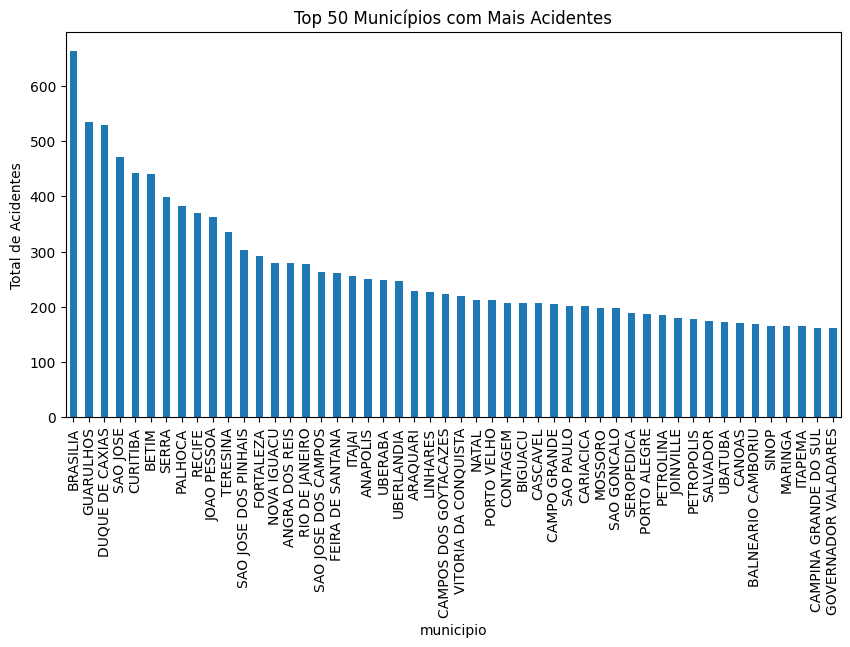

In [ ]:
base_limpa['municipio'].value_counts().head(50).plot(kind='bar', figsize=(10,5))
plt.title('Top 50 Municípios com Mais Acidentes')
plt.ylabel('Total de Acidentes')
plt.show()

**Conclusão:** Podemos observar que o município que mais possui acidentes é Brasília, seguido de Guarulhos e Duque de Caxias. Mas isso por si só pode dizer mais da infraestrutura da cidade do que do estado em si. Pode ser alguma característica peculiar da cidade que leva a este grande número. Várias outras cidades de diversas regiões diferentes no TOP 50 tem mais de 200 acidentes registrados, o que pode nos dar indicativos do que causa um maior número de acidentes.

## Pergunta 7 — O número de veículos envolvidos influencia a gravidade?

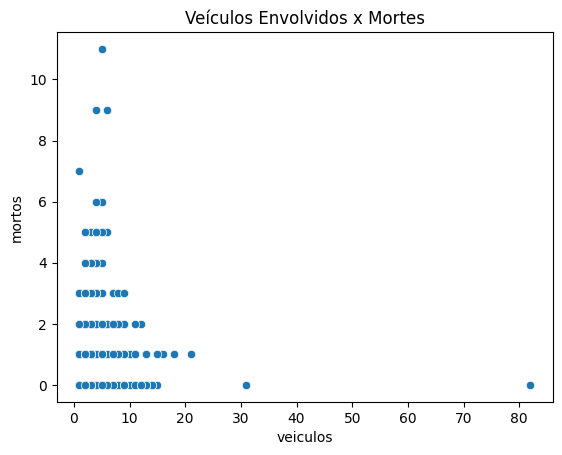

In [ ]:
sns.scatterplot(x='veiculos', y='mortos', data=base_limpa)
plt.title('Veículos Envolvidos x Mortes')
plt.show()

**Conclusão:** Pela matriz de correlação no começo do notebook, vemos que existe sim uma correlação positiva — acidentes com múltiplos veículos tendem a ser mais graves. Mas o gráfico apresentado aqui indica que essa correlação não é tão forte, pelo menos se considerarmos mortes como um acidente grave.

## Pergunta 8 — Quais estados (UFs) registram mais acidentes fatais?

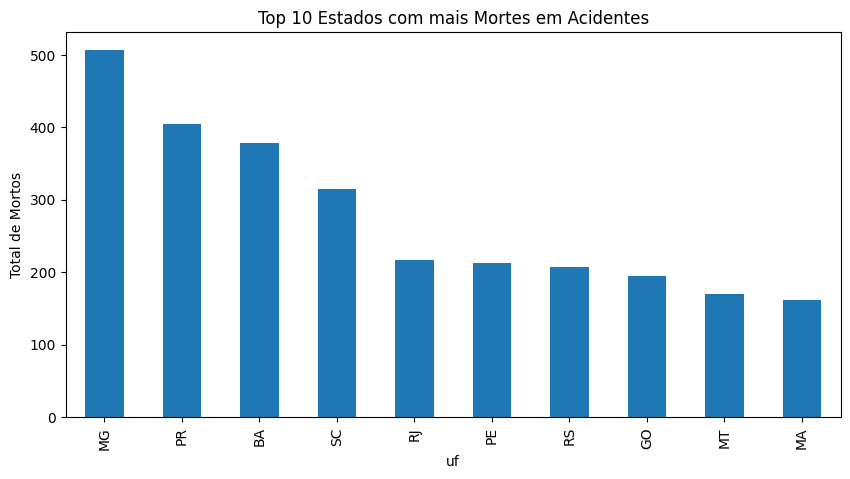

In [ ]:
top_ufs = base_limpa.groupby('uf')['mortos'].sum().sort_values(ascending=False).head(10)
top_ufs.plot(kind='bar', figsize=(10,5))
plt.title('Top 10 Estados com mais Mortes em Acidentes')
plt.ylabel('Total de Mortos')
plt.show()

**Conclusão:** Estados com grandes extensões de rodovias federais, como Minas Gerais e Bahia, concentram o maior número de mortes.

### Análise geral dos casos de acidentes

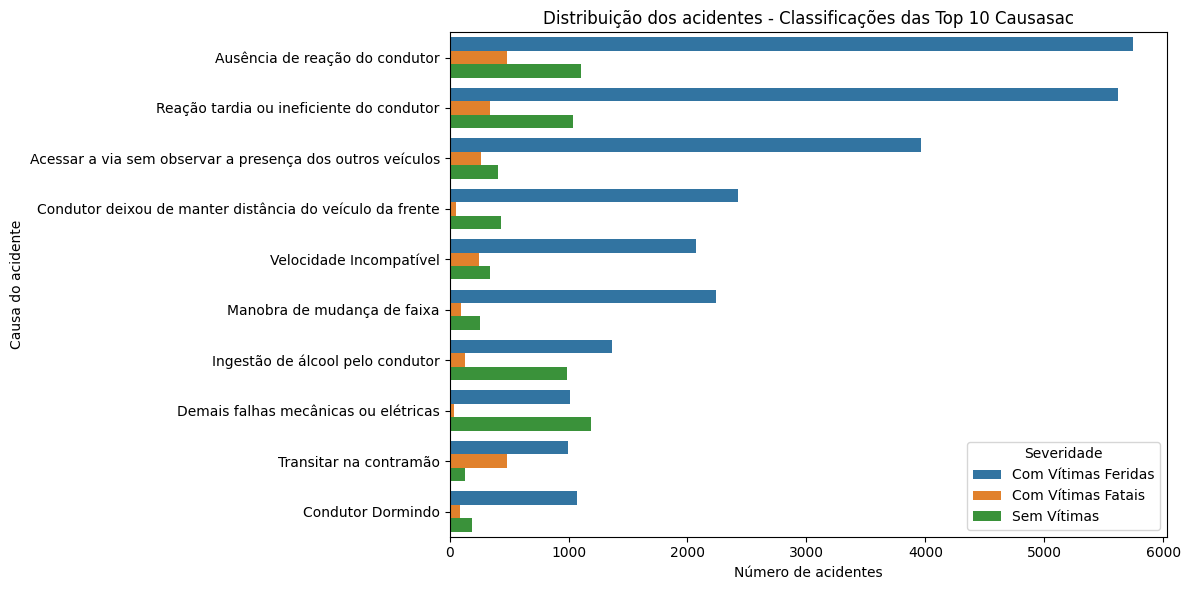

In [ ]:
plt.figure(figsize=(12, 6))
base_limpa_temp = base_limpa[base_limpa['classificacao_acidente'] != '-']
sns.countplot(y='causa_acidente', hue='classificacao_acidente', data=base_limpa_temp, order=base_limpa_temp['causa_acidente'].value_counts().index[:10])
plt.title('Distribuição dos acidentes - Classificações das Top 10 Causasac')
plt.xlabel('Número de acidentes')
plt.ylabel('Causa do acidente')
plt.legend(title='Severidade')
plt.tight_layout()
plt.show()

## Síntese dos resultados:

- Colisões e saídas de pista são os tipos de acidente mais recorrentes.
- A maioria ocorre em **tempo bom** e **em pleno dia**, o que reforça a importância de fatores humanos.
- Há **picos de acidentes no final da tarde e nos finais de semana**.
- Pistas simples e trechos de longa extensão tendem a apresentar maior severidade.
- Reação tardia ou ineficiente do condutor é o maior causador de acidentes, enquanto que transitar na contramão foi o que mais gerou acidentes com vítimas fatais.

**Limitações:**  
Algumas variáveis categóricas apresentam valores genéricos (“não informado”), e os dados não incluem informações sobre uso de cinto ou embriaguez, o que limita o detalhamento da causa.

**Pontos de evolução:**
Ter dados sobre os municípios em si pode levar a descobertas interessantes, como por exemplo, do motivo de Brasília e Guarulhos serem os municípios com mais quantidade de acidentes.




# Parte 2: Modelagem e Avaliação (ML)

**Objetivo:** queremos criar um algoritmo de ML
para **classificar se há mortes ou não em casos de acidente**, dado determinados parâmetros de uma pista.

Esse problema é relevante pois, além de ajudar na prevenção de riscos, também auxila na detecção de pistas com problemas que aumentam os riscos.

<ul>
  <li><b>Exemplo 1</b>: Se eu sei que o trajeto A é mais perigoso e possui risco de acidente fatal ao meio dia, mas que esse mesmo trajeto às 16:00 não apresenta o mesmo risco, posso planejar melhor para evitar mortes.</li>

  <li><b>Exemplo 2</b>: se a previsão mostra que uma dada pista sempre tem acidentes fatais quando há mais de um veículo envolvido no acidente, uma possivel solução é planejar expandir a pista (simples -> dupla ou dupla -> tripla).</li>
</ul>



---



**Técnicas de Aprendizado de Máquina Utilizadas**

Selecionamos quatro técnicas de classificação para avaliar qual delas oferece o melhor balanceamento entre precisão e recall (medido pelo F1-Score) para a classe minoritária (acidentes com mortes):



1.   **Regressão Logística (Logistic Regression):**  
É um algoritmo de modelo linear utilizado para problemas de classificação binária ou multi-classe. Ele estima a probabilidade de uma ocorrência pertencer a uma determinada classe, ajustando os coeficientes das features de entrada por meio de uma função logística (ou sigmoid). Apesar do nome "Regressão", é uma técnica fundamentalmente de classificação.

2.   **Árvore de Decisão (Decision Tree):**
      
      É um algoritmo não-linear que funciona dividindo o conjunto de dados em subconjuntos menores de forma recursiva, com base em critérios de features (como Gini Impurity ou Entropia). O resultado final é uma estrutura de árvore simples, onde cada nó interno representa um teste em um atributo, cada ramo representa o resultado do teste, e cada nó folha representa uma decisão de classificação.
    
3.  **Random Forest (Floresta Aleatória):**
      
      É um modelo de ensemble baseado no método Bagging (Bootstrap Aggregating). O Random Forest constrói múltiplas Árvores de Decisão durante o treinamento e gera a predição final votando nas saídas de cada árvore. Isso ajuda a mitigar o problema de overfitting comum em Árvores de Decisão únicas, resultando em maior robustez e melhor precisão.
    


---



→ Com as técnicas acima, iniciamos a leitura e preparação a base para as analises:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Lendo a base inicial
def ler_base_inicial(rodar_local = True):

  if(rodar_local):
    base = pd.read_csv('/content/datatran2025.csv', encoding='latin1', sep=';')
    base.columns
  else:
    from google.colab import drive
    file_path = '/content/drive/MyDrive/Databases Projeto/datatran2025.xlsx'

    # Carregue o DataFrame
    try:
        base = pd.read_excel(file_path)#, encoding='latin1', sep=';')
        print("DataFrame carregado com sucesso!")
    except FileNotFoundError:
        print(f"Erro: O arquivo não foi encontrado no caminho especificado: {file_path}")
    except Exception as e:
        print(f"Ocorreu um erro ao carregar o arquivo: {e}")
  base.columns

  return base

def limpar_dados(base):
  # Tirando duplicatas
  base_limpa = base.drop_duplicates()

  # Removendo colunas irrelevantes (ID)
  base_limpa = base_limpa.drop(columns={'id'})

  # Lidando com NaNs
  base_limpa.loc[base_limpa['classificacao_acidente'].isna(), 'classificacao_acidente'] = '-'
  base_limpa.loc[base_limpa['regional'].isna(), 'regional'] = '-'
  base_limpa.loc[base_limpa['delegacia'].isna(), 'delegacia'] = '-'
  base_limpa.loc[base_limpa['uop'].isna(), 'uop'] = '-'

  # Marcando acidentes fatais
  base_limpa.loc[base_limpa['mortos'] > 0, 'ha_mortes'] = '1'
  base_limpa.loc[base_limpa['mortos'] == 0, 'ha_mortes'] = '0'

  # Corrigindo virgula para ponto na coluna km, latitude e longetude
  base_limpa['km'] = base_limpa['km'].apply(lambda x: str(x).replace(',', '.'))
  base_limpa['latitude'] = base_limpa['latitude'].apply(lambda x: str(x).replace(',', '.'))
  base_limpa['longitude'] = base_limpa['longitude'].apply(lambda x: str(x).replace(',', '.'))

  # Deixando as strings em minusculo
  colunas_string = base_limpa.select_dtypes(include=['object']).columns
  for col in colunas_string:
      if(col not in ['horario']):
        base_limpa[col] = base_limpa[col].str.lower()

  # Corrigindo caracteres
  base_limpa['classificacao_acidente'] = base_limpa['classificacao_acidente'].str.replace('�', 'i')
  return base_limpa

In [2]:
base = ler_base_inicial()
base_limpa = limpar_dados(base)


▶ O objetivo central deste trabalho é desenvolver e avaliar um modelo de Machine Learning (ML) capaz de realizar uma tarefa de classificação binária: prever se um acidente de trânsito resultará em mortes ou não, com base nas características da via e do momento do evento.

Para isso, iniciamos criando a variável Target ha_mortes, onde:


*   0 (Classe Negativa): Ausência de vítimas fatais.
*   1 (Classe Positiva): Presença de uma ou mais vítimas fatais.

---

Para evitar o vazamento de dados (data leakage), que ocorre quando informações do Target são incluídas nas variáveis de Feature, e para otimizar o processamento, removemos colunas que contêm dados pós-acidente (como contagens de vítimas) ou informações que são duplicadas/irrelevantes para a predição.

▶ **As variáveis removidas foram:**

data_inversa, causa_acidente, tipo_acidente, classificacao_acidente, tracado_via, feridos_leves, feridos_graves, ilesos, ignorados, feridos, regional, delegacia, municipio, br e uop.

---
▶ **Codificação de Variáveis:**

Para que as variáveis categóricas pudessem ser processadas pelos algoritmos de Machine Learning, utilizamos a técnica One-Hot Encoding (OHE), que transforma cada categoria em uma nova coluna binária (0 ou 1). A variável target 'morte' é numérica, mas para classificação multi-classe, é melhor garantir que ela seja tratada como categórica.

---

▶ **O Problema:**

A base de dados apresenta um desbalanceamento de classes, conforme demonstrado pela contagem de valores (value_counts) abaixo. A grande maioria dos acidentes (Classe 0) não resulta em mortes, tornando a Classe 1 uma minoria significativa.

Este desbalanceamento exige atenção, pois modelos treinados sem ajustes tendem a ser altamente precisos na classe majoritária, mas ineficazes na detecção da classe minoritária, que é o foco do nosso problema.

▶ Portanto, para mitigar o efeito do desbalanceamento e comparar o desempenho dos modelos da melhor forma, adotamos as seguintes estratégias:

1.   **Modelos Múltiplos:**  Utilizaremos um conjunto de algoritmos de classificação (Regressão Logística, Árvore de Decisão, Random Forest e LightGBM) para testar qual arquitetura performa melhor.

2.   **Ponderação de Classes:** Ativamos o parâmetro de ponderação de classes (class_weight='balanced' no Scikit-learn), onde aplicável. Este mecanismo atribui um peso maior aos exemplos da classe minoritária durante o treinamento, forçando o modelo a dar mais importância à sua correta classificação.

3. **Métrica Principal (F1-Score):** Em vez de confiar apenas na Acurácia (que seria artificialmente alta devido à Classe 0), utilizaremos o F1-Score como métrica primária. O F1-Score é a média harmônica entre Precisão e Recall, sendo ideal para avaliar o desempenho em classes desbalanceadas, pois penaliza modelos que falham ao prever a classe minoritária.



In [ ]:
base_limpa['ha_mortes'].value_counts().reset_index()

,ha_mortes,count
0,0,43770
1,1,3422


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold # Adicionado GridSearchCV e StratifiedKFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score # Adicionado make_scorer e f1_score
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

# Supondo que 'base_limpa' foi carregada nas células anteriores
# Ex: base = ler_base_inicial(); base_limpa = limpar_dados(base)
df = base_limpa

print("Iniciando Pré-processamento...")

# Extração da hora ('horario')
df['hora'] = df['horario'].apply(lambda x: int(x.split(':')[0]))

# Variáveis categóricas a serem codificadas com One-Hot Encoding e numéricas
categorical_features = [
    'dia_semana', 'uf', 'tipo_acidente',
    'fase_dia', 'sentido_via', 'condicao_metereologica',
    'tipo_pista', 'uso_solo', 'hora' # 'hora' é agora uma feature categórica (discreta)
]
numerical_features = ['km', 'pessoas', 'veiculos', 'latitude', 'longitude']
cols_to_use = categorical_features + numerical_features + ['ha_mortes']
df = df[cols_to_use]

# Colunas para One-Hot Encoding
categorical_features_ohe = [col for col in categorical_features if col != 'hora']
discrete_features = ['hora']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_features_ohe),
        ('passthrough', 'passthrough', numerical_features)
    ],
    remainder='passthrough'
)

# Separação de X (features) e y (target)
X = df.drop('ha_mortes', axis=1)
y = df['ha_mortes']

# Divisão em conjuntos de treino e teste (80 treino e 20 teste)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Modelos e Pipeline de Treinamento
# Dicionário para armazenar modelos e resultados. Random Forest simples removido.
models = {
    'Regressão Logística': LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42, class_weight='balanced'),
    'Árvore de Decisão': DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

results = {}

# =================================================================
## 3.1. Otimização de Hiperparâmetros com GridSearchCV (Random Forest)
# =================================================================

print("\nIniciando Grid Search para Random Forest (Otimização de Hiperparâmetros)...")

# 1. Definição do Modelo Base e Parâmetros
rf_base = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Definição do Pipeline (usa o mesmo preprocessor)
rf_pipeline_gs = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', rf_base)])

# 3. Grade de Hiperparâmetros a serem testados
param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [5, 10, None], # None significa sem limite de profundidade
    'classifier__min_samples_split': [2, 5]
}

# 4. Configuração do Grid Search com Validação Cruzada (cv=3)
# Otimizando para o F1-Score da classe positiva ('1')
scorer_f1 = make_scorer(f1_score, pos_label='1')

grid_search_rf = GridSearchCV(
    estimator=rf_pipeline_gs,
    param_grid=param_grid_rf,
    scoring=scorer_f1, # Métrica de otimização
    cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42), # Garante representação das classes
    verbose=1,
    n_jobs=-1 # Usa todos os núcleos
)

# 5. Treinamento e Seleção do Melhor Modelo
grid_search_rf.fit(X_train, y_train)

# Armazenando o Melhor Modelo e Resultados
best_rf_model = grid_search_rf.best_estimator_

# Adicionando o melhor modelo do Grid Search ao dicionário 'models'
models['Random Forest (Otimizado)'] = best_rf_model.named_steps['classifier']
print(f"\nMelhores parâmetros para Random Forest: {grid_search_rf.best_params_}")
print(f"Melhor F1-Score (Treino, CV): {grid_search_rf.best_score_:.4f}")

# 6. Avaliação do Modelo Otimizado (os resultados são armazenados no 'results'
# e serão exibidos no bloco de Apresentação de Resultados)
y_pred_rf = best_rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
report_rf = classification_report(y_test, y_pred_rf, zero_division=0)
conf_mat_rf = confusion_matrix(y_test, y_pred_rf)

results['Random Forest (Otimizado)'] = {
    'Acurácia': accuracy_rf,
    'Relatório de Classificação': report_rf,
    'Matriz de Confusão': conf_mat_rf
}
# =================================================================

print("\nTreinando e Avaliando Modelos RESTANTES...")

# Este loop agora treina e avalia LogReg, Árvore de Decisão e LightGBM
for name, model in models.items():
    # O modelo Random Forest (Otimizado) já foi treinado acima (grid_search_rf.fit) e seus
    # resultados já foram colocados em 'results'. Por isso, pulamos ele aqui.
    if "Otimizado" in name:
        continue

    # Cria o pipeline: Pré-processamento -> Modelo
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])

    # Treinamento
    pipeline.fit(X_train, y_train)

    # Predição
    y_pred = pipeline.predict(X_test)

    # Avaliação
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=0)
    conf_mat = confusion_matrix(y_test, y_pred)

    results[name] = {
        'Acurácia': accuracy,
        'Relatório de Classificação': report,
        'Matriz de Confusão': conf_mat
    }

# 4. Apresentação dos Resultados (Métricas)

print("\n" + "="*50)
print("             🏆 Resultados dos Modelos 🏆")
print("="*50)

for name, res in results.items():
    print(f"\n## 📈 Modelo: {name}")
    print("-" * (len(name) + 10))
    print(f"*Acurácia*: {res['Acurácia']:.4f}")

    # Relatório de Classificação (Acurácia, Precisão, Recall, F1-Score)
    print("\n*Relatório de Classificação (Precision, Recall, F1-Score)*:\n")
    print(res['Relatório de Classificação'])

    # Matriz de Confusão
    print("\n*Matriz de Confusão*:")
    print(res['Matriz de Confusão'])
    print("-" * 50)

Iniciando Pré-processamento...

Iniciando Grid Search para Random Forest (Otimização de Hiperparâmetros)...
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Melhores parâmetros para Random Forest: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 150}
Melhor F1-Score (Treino, CV): 0.3465

Treinando e Avaliando Modelos RESTANTES...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



             🏆 Resultados dos Modelos 🏆

## 📈 Modelo: Random Forest (Otimizado)
-----------------------------------
*Acurácia*: 0.8317

*Relatório de Classificação (Precision, Recall, F1-Score)*:

              precision    recall  f1-score   support

           0       0.97      0.85      0.90      8762
           1       0.24      0.61      0.34       677

    accuracy                           0.83      9439
   macro avg       0.60      0.73      0.62      9439
weighted avg       0.91      0.83      0.86      9439


*Matriz de Confusão*:
[[7439 1323]
 [ 266  411]]
--------------------------------------------------

## 📈 Modelo: Regressão Logística
-----------------------------
*Acurácia*: 0.7838

*Relatório de Classificação (Precision, Recall, F1-Score)*:

              precision    recall  f1-score   support

           0       0.97      0.79      0.87      8762
           1       0.20      0.69      0.31       677

    accuracy                           0.78      9439
   macro av

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


▶ Análise dos Resultados e Conclusão 📊

A análise dos resultados mostra que, embora os modelos LightGBM (92.87%) e Árvore de Decisão (88.62%) apresentem as acurácias mais elevadas, essa métrica é enganosa devido ao forte desbalanceamento de classes do dataset (cerca de 93% dos registros são acidentes sem mortes).

A métrica mais crítica para avaliar o sucesso em prever fatalidades é o F1-Score da classe positiva (1), pois ela combina Precisão e Recall e é mais robusta em cenários desbalanceados.

▶  **Comparativo de Desempenho (F1-Score da Classe Positiva - Mortes):**



In [ ]:
import pandas as pd
from sklearn.metrics import classification_report # Re-importar, se necessário

# 1. Preparar a lista de resultados formatados
comparativo_data = []

for name, res in results.items():
    # Extrai o relatório de classificação para obter as métricas da classe '1'
    report_dict = classification_report(y_test,
                                        best_rf_model.predict(X_test) if "Otimizado" in name else Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models[name])]).predict(X_test),
                                        output_dict=True, zero_division=0)

    # Obter o modelo/pipeline. Se for o otimizado, usamos 'best_rf_model'.
    if "Otimizado" in name:
        model_to_predict = best_rf_model
    else:
        # Re-criar o pipeline para modelos que não são RF Otimizado
        model_to_predict = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models[name])])
        model_to_predict.fit(X_train, y_train) # Re-treina para garantir (embora já estejam treinados)

    y_pred_re = model_to_predict.predict(X_test)
    report_dict_re = classification_report(y_test, y_pred_re, output_dict=True, zero_division=0)

    # Extrair as métricas da classe '1' (positiva)
    prec_1 = report_dict_re['1']['precision']
    recall_1 = report_dict_re['1']['recall']
    f1_1 = report_dict_re['1']['f1-score']

    comparativo_data.append({
        'Modelo': name,
        'Acurácia': res['Acurácia'],
        'Precisão (Classe 1)': prec_1,
        'Recall (Classe 1)': recall_1,
        'F1-Score (Classe 1)': f1_1
    })

# 2. Criar o DataFrame
df_comparativo = pd.DataFrame(comparativo_data)

# 3. Formatar as colunas de métricas
format_dict = {
    'Acurácia': '{:.4f}',
    'Precisão (Classe 1)': '{:.4f}',
    'Recall (Classe 1)': '{:.4f}',
    'F1-Score (Classe 1)': '{:.4f}'
}
df_comparativo = df_comparativo.style.format(format_dict).hide(axis='index')

# 4. Exibir a Tabela
print("\n" + "="*70)
print("             Tabela 1: Comparativo de Desempenho dos Modelos")
print("="*70)
# No Colab, usar display() ou apenas o nome da variável no final da célula renderiza a tabela
display(df_comparativo)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1237: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, binary problems will be fit as proper binary  logistic regression models (as if multi_class='ovr' were set). Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but L


             Tabela 1: Comparativo de Desempenho dos Modelos


Modelo,Acurácia,Precisão (Classe 1),Recall (Classe 1),F1-Score (Classe 1)
Random Forest (Otimizado),0.8317,0.2370,0.6071,0.3409
Regressão Logística,0.7838,0.2030,0.6883,0.3135
Árvore de Decisão,0.8862,0.2292,0.2482,0.2383
LightGBM,0.9287,0.5182,0.0842,0.1449


▶ **Interpretação e Pontos Críticos**



1.   **Efeito do LightGBM:**  Embora tenha alta Precisão na classe 1 (0.52), seu Recall é extremamente baixo (0.08), significando que ele classifica incorretamente a vasta maioria dos acidentes fatais como não-fatais. Isso o torna o pior modelo para a tarefa de prevenção.

2.   **Impacto da Otimização:**
A aplicação do GridSearchCV no Random Forest resultou em uma melhoria notável. O Random Forest Otimizado atingiu um F1-Score de 0.34 para a classe minoritária, superando o desempenho de todos os modelos simples testados, incluindo o antigo modelo mais consistente (Regressão Logística com F1=0.31).

3. **Modelo Mais Consistente:** O Random Forest Otimizado passa a ser o modelo mais promissor. Seu equilíbrio entre Precisão (0.24) e Recall (0.61) é o melhor do grupo, indicando uma capacidade superior de identificar acidentes fatais (Recall mais alto) com menos falsos positivos do que a Regressão Logística.

▶  **Conclusões**

Embora o modelo otimizado tenha melhorado o desempenho, o F1-Score de 0.34 ainda é considerado baixo, reforçando que detectar acidentes fatais é uma tarefa desafiadora devido à raridade do evento.

Como caminhos de melhoria e futuras etapas, recomenda-se:

*   **Aprofundar a Otimização:** Testar um espaço de hiperparâmetros ainda maior ou utilizar técnicas mais avançadas como Random Search ou Otimização Bayesiana para encontrar configurações que maximizem o Recall sem comprometer drasticamente a Precisão.
*   **Técnicas de Balanceamento:**  Aplicar explicitamente técnicas de reamostragem como Oversampling (SMOTE), Undersampling, ou uma combinação híbrida, para tornar o treinamento mais equilibrado.
*   **Modelos de Boosting Robusto:** Explorar outros modelos de Gradient Boosting conhecidos por sua robustez em desbalanceamento, como o XGBoost ou CatBoost.
*   **Engenharia de Variáveis:** Criar novas features de interação ou de agregação que possam capturar a complexidade da condição de risco, melhorando o poder preditivo do modelo.

▶ **Análise gráfica das distribuições de Classes:**

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


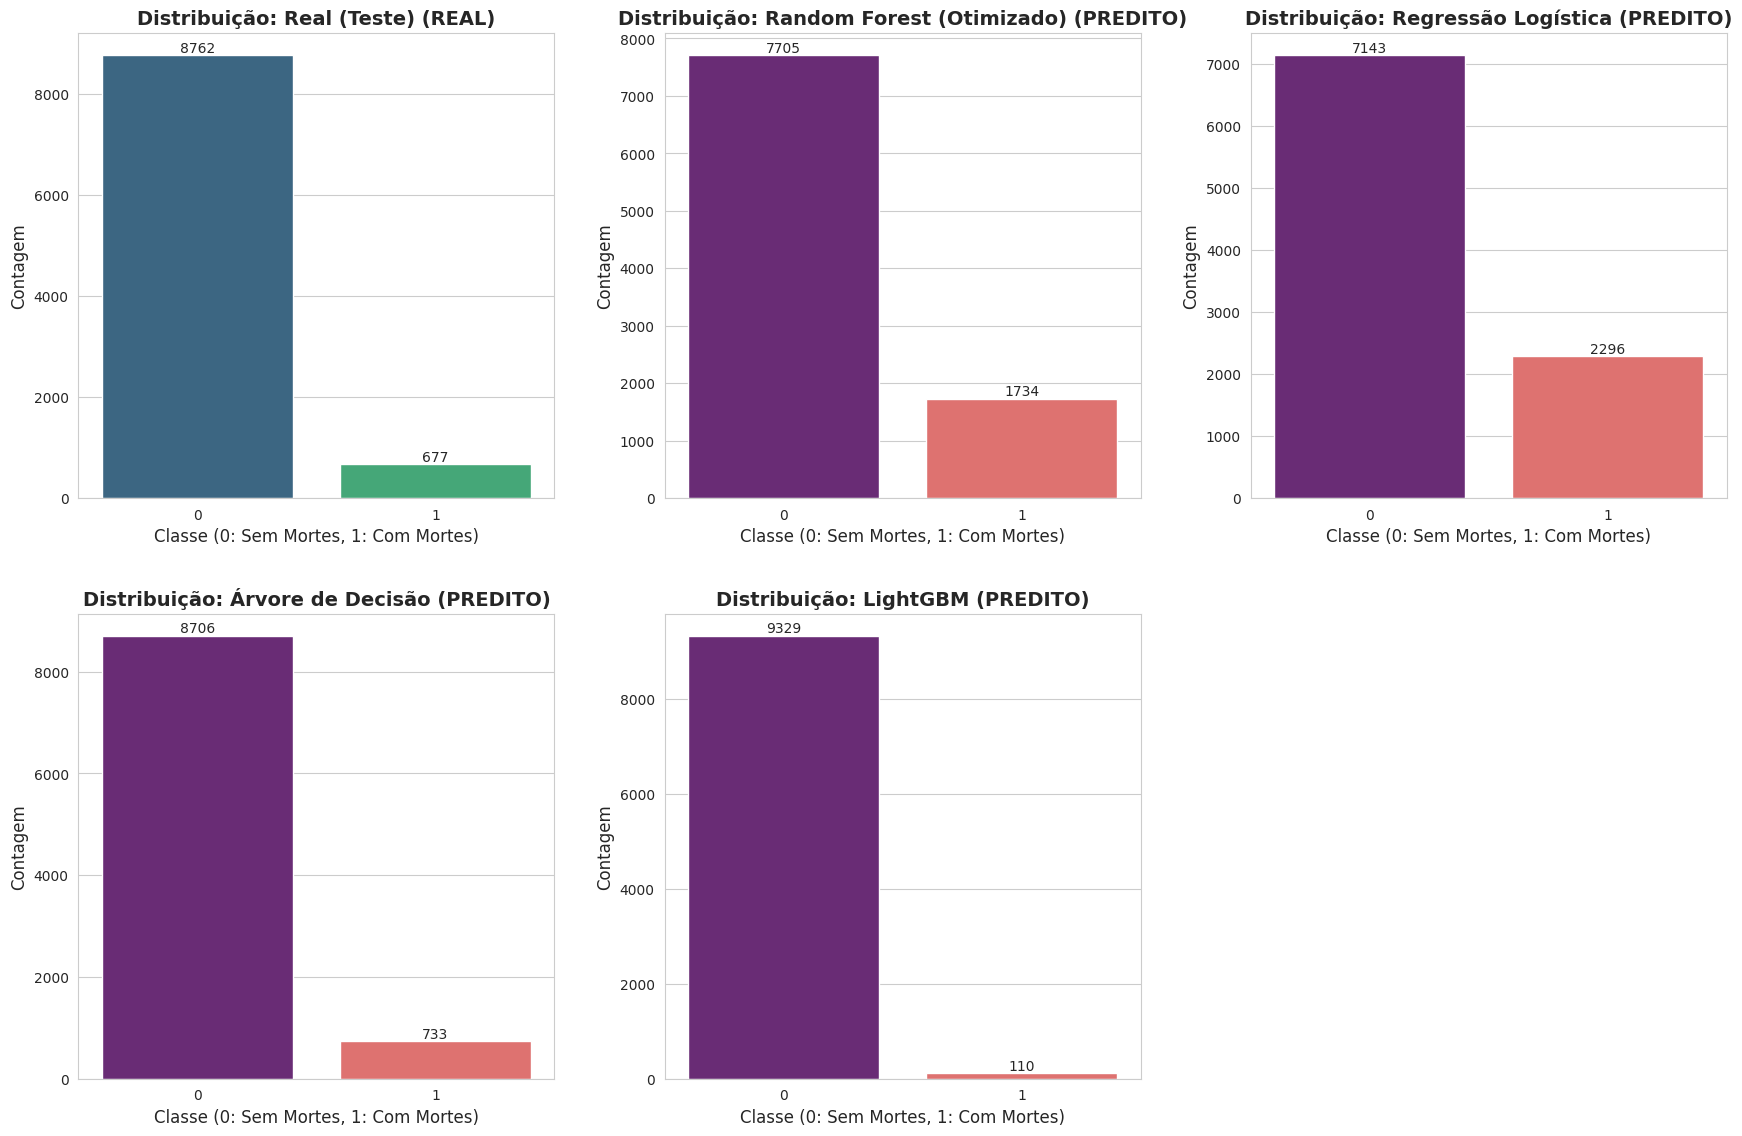

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
# Certifique-se de que 'models', 'results', 'preprocessor', X_train, y_train, X_test e y_test estão definidos!

# Set a style for better aesthetics
sns.set_style("whitegrid")

# Dicionário que mapeia o nome do modelo ao seu objeto (modelo treinado ou pipeline)
# É necessário reverter o modelo do dicionário 'models' para o objeto Pipeline para predição
# O Random Forest Otimizado já está em 'best_rf_model' (que é um Pipeline completo)

all_models = {
    'Real (Teste)': None, # Placeholder para a distribuição real
    'Random Forest (Otimizado)': best_rf_model,
    'Regressão Logística': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Regressão Logística'])]),
    'Árvore de Decisão': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['Árvore de Decisão'])]),
    'LightGBM': Pipeline(steps=[('preprocessor', preprocessor), ('classifier', models['LightGBM'])]),
}

# Treinar os pipelines simples (embora já treinados, é bom garantir)
for name, pipeline in all_models.items():
    if pipeline is not None and not isinstance(pipeline, Pipeline):
        pipeline.fit(X_train, y_train)


# Determine o número de plots necessários (1 para o real + 4 modelos)
total_plots = len(all_models) # 5 plots

# Calcula as dimensões da grade (2 linhas, 3 colunas)
n_cols = 3
n_rows = (total_plots + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, n_rows * 6))
axes = axes.flatten() # Achata o array de eixos para fácil iteração

for i, (name, model_pipeline) in enumerate(all_models.items()):
    ax = axes[i] # Inicia do primeiro subplot

    if name == 'Real (Teste)':
        # Plot da distribuição real dos labels de teste
        y_data = y_test
        palette = 'viridis'
        title_suffix = " (REAL)"
    else:
        # Plot da distribuição predita pelo modelo
        try:
            # Garante que o pipeline é usado para predição
            y_data = model_pipeline.predict(X_test)
        except Exception as e:
            # Caso haja algum erro de predição, usa uma array vazia
            print(f"Erro ao predizer com {name}: {e}")
            y_data = np.array([])

        palette = 'magma'
        title_suffix = " (PREDITO)"

    # Plotagem da contagem
    if len(y_data) > 0:
        sns.countplot(x=y_data, hue=y_data, legend=False, palette=palette, ax=ax)

        # Adiciona os valores de contagem nas barras
        for container in ax.containers:
            ax.bar_label(container, fmt='%d', fontsize=10)

    ax.set_title(f"Distribuição: {name}{title_suffix}", fontsize=14, fontweight='bold')
    ax.set_xlabel("Classe (0: Sem Mortes, 1: Com Mortes)", fontsize=12)
    ax.set_ylabel("Contagem", fontsize=12)
    ax.tick_params(axis='x', rotation=0)

# Oculta quaisquer subplots não utilizados
for j in range(total_plots, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=3.0) # Ajusta o layout para evitar sobreposição
plt.show()

Os gráficos de distribuição de classes visam ilustrar o desafio do desbalanceamento e o comportamento de predição de cada modelo:

▶ **Gráfico 1:** Distribuição Real (Teste)

**O que representa:** A distribuição real de classes no conjunto de dados utilizado para testar todos os modelos.

**Análise:** Este gráfico é o ponto de referência. Ele confirma o alto desbalanceamento: a Classe 0 (Sem Mortes) domina largamente, e a Classe 1 (Com Mortes) é uma minoria estatística (o evento raro que queremos prever).

---

▶ **Gráfico 2:** Distribuição Predita: Random Forest (Otimizado)

**O que representa:** As predições feitas pelo Random Forest após otimizar seus hiperparâmetros (Grid Search).

**Análise:** Comparado aos modelos LightGBM e Árvore de Decisão, o Random Forest Otimizado mostra uma barra da Classe 1 visivelmente maior. Isso indica que o modelo está mais disposto a classificar casos como fatais (Classe 1) para aumentar o Recall (identificação de fatalidades reais), o que é a estratégia correta para lidar com o desbalanceamento do problema.

---

**Gráfico 3:** Distribuição Predita: Regressão Logística

**O que representa:** As predições feitas pela Regressão Logística.

**Análise:** Assim como o Random Forest Otimizado, este modelo também mostra uma barra da Classe 1 substancialmente maior que os modelos de alta acurácia (LightGBM e Árvore de Decisão). Ele é o segundo modelo mais agressivo na predição da Classe 1, buscando um bom Recall.

---

**Gráfico 4:** Distribuição Predita: Árvore de Decisão

**O que representa:** As predições feitas pela Árvore de Decisão.

**Análise:** Este gráfico se assemelha muito à distribuição real. O modelo é muito conservador e classifica a maioria esmagadora dos casos como Classe 0. Embora isso mantenha a acurácia alta, significa que ele falha em identificar a maioria dos acidentes fatais (baixo Recall).

---

**Gráfico 5:** Distribuição Predita: LightGBM

**O que representa:** As predições feitas pelo LightGBM.

**Análise:** Este modelo é o mais conservador (ou "enviesado") em relação à classe majoritária. Sua barra da Classe 1 é extremamente pequena, quase nula. O modelo essencialmente replica o desbalanceamento real, priorizando a Acurácia e, consequentemente, falhando em capturar a Classe 1 (F1-Score muito baixo para fatalidades).



**▶ Conclusão Geral dos Gráficos**

A análise visual dos gráficos reforça a conclusão de que Acurácia é uma métrica inadequada para este problema. Os modelos com a maior Acurácia (LightGBM e Árvore de Decisão) são os que mais se parecem com a distribuição real, pois simplesmente aprendem a apostar na classe majoritária (0).

Por outro lado, os modelos que obtiveram o melhor F1-Score (Random Forest Otimizado e Regressão Logística) são aqueles que mais se afastaram da distribuição real, demonstrando um esforço  para classificar mais casos como Classe 1. Esse desvio intencional é o que garante um Recall mais alto e, consequentemente, maior utilidade prática para a prevenção de fatalidades.